In [5]:
import pandas as pd

# Read the dataset
file_path = 'stress_detection.csv'
df = pd.read_csv(file_path)
df.head()

,participant_id,day,PSS_score,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism,sleep_time,wake_time,sleep_duration,PSQI_score,call_duration,num_calls,num_sms,screen_on_time,skin_conductance,accelerometer,mobility_radius,mobility_distance
0,1,1,34,2.322732,4.332193,1.185878,1.570213,3.782094,7.726792,5.190660,6.572069,1,3.924527,12,32,10.703714,3.115730,0.161717,1.145179,2.196851
1,1,2,37,1.761436,3.254120,3.907281,4.072512,1.997145,7.312674,6.170717,8.030168,4,58.318004,3,41,11.012939,0.959144,0.985587,1.021133,0.737825
2,1,3,30,3.025887,1.855002,2.045900,2.317493,3.619225,6.992060,5.318825,7.102420,1,4.941043,4,48,4.877372,3.311629,1.877445,0.478179,0.911673
3,1,4,16,1.948370,4.966676,3.345225,1.607756,3.583524,8.886914,8.061075,8.123294,3,0.295373,11,38,3.462956,0.625721,0.494921,0.630549,3.911418
4,1,5,32,3.343484,2.065936,3.137843,2.118061,2.567347,7.811705,7.312145,7.785143,3,22.300571,17,17,4.861046,0.622609,1.342600,0.254090,1.605132



Classification Report:
               precision    recall  f1-score   support

   Low Stress       0.35      0.39      0.37       204
Medium Stress       0.33      0.31      0.32       213
  High Stress       0.30      0.28      0.29       183

     accuracy                           0.33       600
    macro avg       0.33      0.33      0.33       600
 weighted avg       0.33      0.33      0.33       600


<Figure size 1200x600 with 0 Axes>

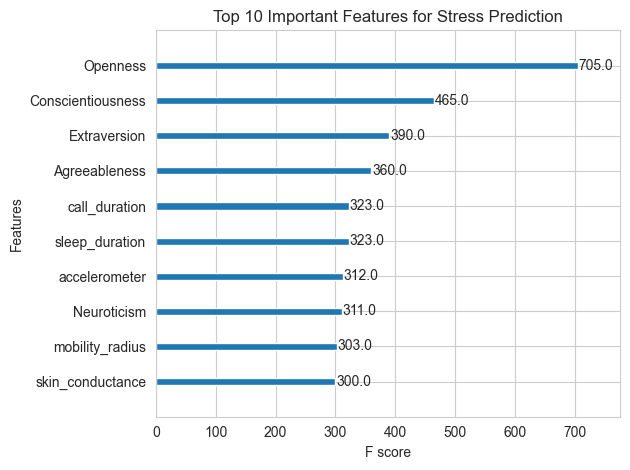

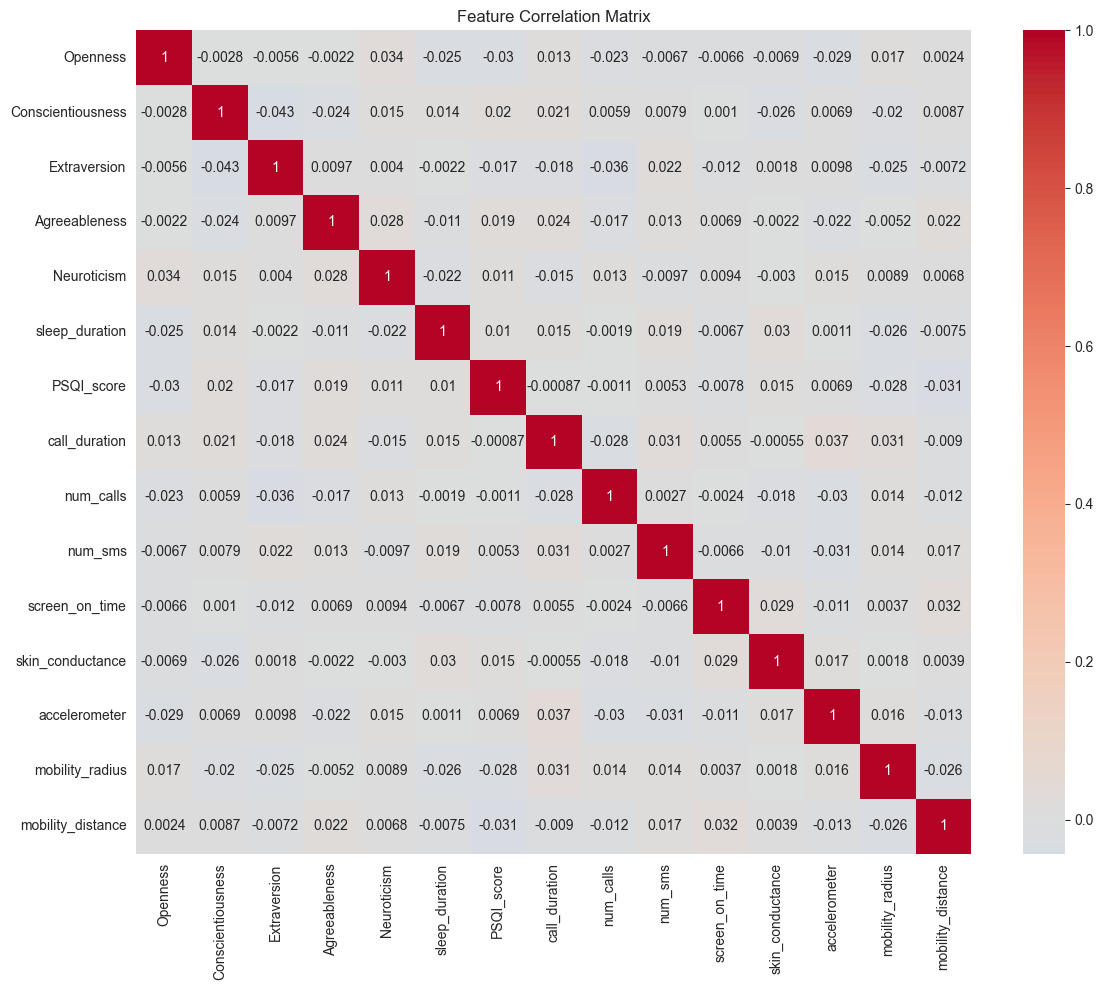

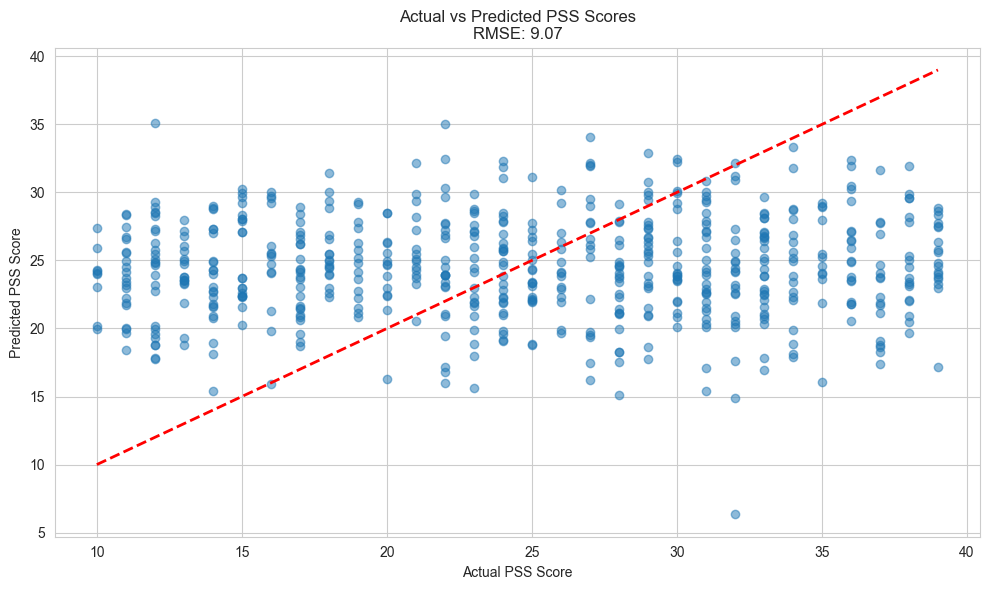

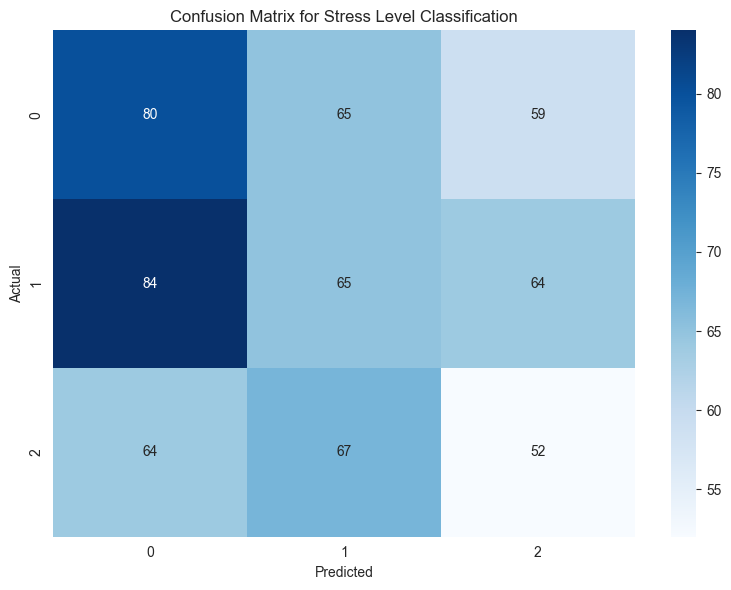

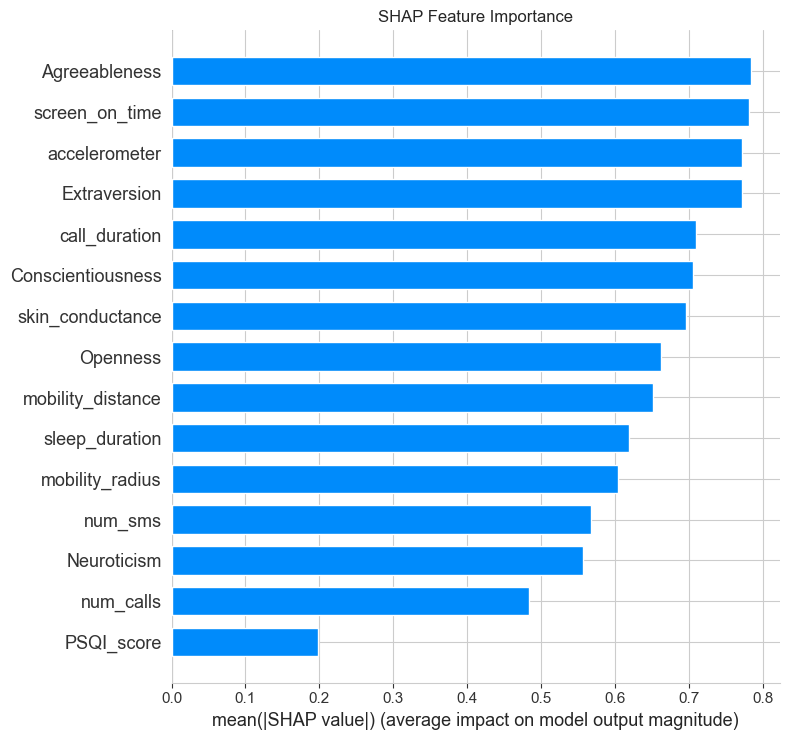

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
import shap

def bin_stress_levels(pss_score):
    """Convert PSS scores into stress level categories"""
    if pss_score <= 20:
        return 0  # Low stress
    elif pss_score <= 30:
        return 1  # Medium stress
    else:
        return 2  # High stress

def prepare_data(df):
    """Prepare data for modeling"""
    # Create stress level categories
    df['stress_level'] = df['PSS_score'].apply(bin_stress_levels)
    
    # Split features and targets
    feature_cols = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 
                   'Neuroticism', 'sleep_duration', 'PSQI_score', 'call_duration',
                   'num_calls', 'num_sms', 'screen_on_time', 'skin_conductance',
                   'accelerometer', 'mobility_radius', 'mobility_distance']
    
    X = df[feature_cols]
    y_reg = df['PSS_score']
    y_clf = df['stress_level']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    return X_scaled, y_reg, y_clf, feature_cols

def train_and_evaluate_models(X, y_reg, y_clf):
    """Train and evaluate both regression and classification models"""
    # Split data
    X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
        X, y_reg, y_clf, test_size=0.2, random_state=42
    )
    
    # Train regression model
    reg_model = xgb.XGBRegressor(random_state=42)
    reg_model.fit(X_train, y_reg_train)
    reg_pred = reg_model.predict(X_test)
    reg_rmse = np.sqrt(mean_squared_error(y_reg_test, reg_pred))
    
    # Train classification model
    clf_model = xgb.XGBClassifier(random_state=42)
    clf_model.fit(X_train, y_clf_train)
    clf_pred = clf_model.predict(X_test)
    
    return reg_model, clf_model, X_train, X_test, y_reg_test, y_clf_test, reg_pred, clf_pred, reg_rmse

def create_visualizations(reg_model, clf_model, X, y_reg_test, y_clf_test, reg_pred, clf_pred, 
                         feature_cols, reg_rmse):
    """Create and save visualization plots"""
    # 1. Feature Importance Plot
    plt.figure(figsize=(12, 6))
    xgb.plot_importance(reg_model, max_num_features=10)
    plt.title('Top 10 Important Features for Stress Prediction')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    
    # 2. Correlation Matrix
    plt.figure(figsize=(12, 10))
    correlation_matrix = X.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png')
    
    # 3. Actual vs Predicted Plot (Regression)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_reg_test, reg_pred, alpha=0.5)
    plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
    plt.xlabel('Actual PSS Score')
    plt.ylabel('Predicted PSS Score')
    plt.title(f'Actual vs Predicted PSS Scores\nRMSE: {reg_rmse:.2f}')
    plt.tight_layout()
    plt.savefig('regression_performance.png')
    
    # 4. Confusion Matrix (Classification)
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_clf_test, clf_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix for Stress Level Classification')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    
    # 5. SHAP Values Plot
    explainer = shap.TreeExplainer(reg_model)
    shap_values = explainer.shap_values(X)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance')
    plt.tight_layout()
    plt.savefig('shap_importance.png')

def main():
    # Prepare data
    X, y_reg, y_clf, feature_cols = prepare_data(df)
    
    # Train and evaluate models
    results = train_and_evaluate_models(X, y_reg, y_clf)
    reg_model, clf_model = results[0], results[1]
    X_train, X_test = results[2], results[3]
    y_reg_test, y_clf_test = results[4], results[5]
    reg_pred, clf_pred = results[6], results[7]
    reg_rmse = results[8]
    
    # Create visualizations
    create_visualizations(reg_model, clf_model, X, y_reg_test, y_clf_test, reg_pred, 
                         clf_pred, feature_cols, reg_rmse)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_clf_test, clf_pred, 
                              target_names=['Low Stress', 'Medium Stress', 'High Stress']))

if __name__ == "__main__":
    main()

In [27]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold

In [28]:
X = df.drop(columns=['PSS_score','participant_id','day'])
y = df['PSS_score']

In [29]:
X=StandardScaler().fit_transform(X)

In [30]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor

In [32]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Support Vector Machine": SVR(),
    "K Nearest Neighbors": KNeighborsRegressor(n_neighbors=5),
    "Elastic Net": ElasticNet(),
    "XGBoost": XGBRegressor(n_estimators=1000,max_depth = 4, learning_rate=0.01),
    "LightGBM": LGBMRegressor(n_estimators=1000, learning_rate=0.01, verbose=0),
    # "CatBoost": CatBoostRegressor(n_estimators=1000, learning_rate= 0.01,verbose=0)
}

In [33]:
def model_score(models=models):
    model_scores = []
    for name, model in models.items():
        model.fit(train_x, train_y)
        pred = model.predict(test_x)
        r2 = r2_score(test_y, pred)
        rmse = np.sqrt(mean_squared_error(test_y, pred))
        cross_val_scores = cross_validate(model, X, y, cv=5, scoring=['r2', 'neg_root_mean_squared_error'])
        
        results = {
            "model": name,
            "R2": r2,
            "RMSE": rmse,
            "Cross Validation R2": cross_val_scores['test_r2'].mean(),
            "Cross Validation RMSE": np.mean(-cross_val_scores['test_neg_root_mean_squared_error'])
        }
        
        model_scores.append(results)
    return pd.DataFrame(model_scores)


In [34]:
model_score(models=models)

,model,R2,RMSE,Cross Validation R2,Cross Validation RMSE
0,Linear Regression,0.883106,2.871129,0.884486,2.922310
1,Random Forest,0.881378,2.892267,0.882015,2.953250
2,Decision Tree,0.767536,4.048868,0.770761,4.115133
3,Support Vector Machine,0.845919,3.296331,0.842846,3.410700
4,K Nearest Neighbors,0.691688,4.662846,0.673352,4.917535
5,Elastic Net,0.769311,4.033380,0.761964,4.198444
6,XGBoost,0.881331,2.892843,0.879813,2.980645
7,LightGBM,0.876780,2.947789,0.875717,3.031543
